# Full-CI/厳密対角化

この章では、様々な手法のベンチマークにもなる厳密対角化について説明する。



## 厳密対角化

厳密対角化は、量子多体問題を解く上で最も基本となる手法の一つである。

第2量子化形式で表されるHamiltonianに対して、適切な(多体の)基底を取ることで、Hamiltonianを行列形式に変換できる。
その行列を対角化することで、系のエネルギー固有値と固有状態を求めるという考え方である。

各状態は、$N$個の粒子がそれぞれの軌道にあるかないかを表すビット列で表現される。例えば、軌道が5個で粒子が3個の場合は、$\{ |00111\rangle, |01011\rangle \}$といった具合である。

したがって、Hamiltonianは、この基底に対して${}_5C_3 = 10$次元の行列で表現される。

この行列を対角化することで、系のエネルギー固有値と固有状態を求めることができる。

:::{margin}
筆者は, NCSMと明示的に区別するため、模型空間上の対角化計算をvalence shell modelと呼ぶようにしている。
:::
Configuration interaction (CI)法や原子核分野ではshell modelと呼ばれる。
とくに、すべての核子の自由度を陽に扱うものはNo-core shell model(NCSM)と呼ばれ、
模型空間とよばれる限られた空間でバレンス核子の自由度を扱うものと区別される。
この章では、特に配位に制限を加えないFull-CI法を考える。
一つ注意点として、Fullをつけるかどうかの基準が量子化学など他分野と異なることがある。
原子核のコミュニティにおいては、Fullがつくのは「閉殻芯を仮定しない」場合である。

状態の数が指数関数的に増加するため、厳密対角化は比較的小さな系にしか適用できないが、計算が可能であれば、ベンチマークにもなる重要な手法である。

これはpairing Hamiltonianに限らない。

### 配位のビット表現

解くべき問題が行列の対角化であることはわかったが、ではどのように(多粒子の波動関数の)基底を並べればよいか.
もちろん、基底の選び方は無数にあるが、ここでは、Full-CIのスクラッチ実装のために、
幾つか約束事を決めておこう。

* すべての軌道には、0個か1個の粒子しか存在しない。(Fermion)→ビット列で表現する。
* 軌道の数を$N_q$と書く
* 占有数を$N_{\rm occ}$と書く
* ビット列は、左が上位ビット、右が下位ビットとする。(整数値との対応と同様)
* 軌道は左から順に番号が振られているとする。
  例えば、$N_q=5$の場合、$|10100\rangle$は、軌道1,3に粒子が存在する状態を表す。

この約束のもとで, $N_q=5, N_{\rm occ}=2$の場合の基底を書いてみよう。
以下では, ビット列を8byteの整数(`Int64`)として実装することにする。

$$
\begin{align}
|00011\rangle & = 3 \\
|00101\rangle & = 5 \\
& \vdots \\
|11000\rangle & = 24 
\end{align}
$$

一般にハミルトニアンは高々2体相互作用$(a^\dagger a^\dagger aa)$までしか含まず、
多粒子基底の下で定義されるハミルトニアン行列要素はかなり疎(sparse)になる。

一方で、１粒子基底の数や粒子数などの自由度の増大に対して、
次元が階乗($\approx$ 指数的)で増大するため、ハミルトニアン行列をメモリ上に陽に持つことは、多くの場合非現実的である。

そこで、なんらかsparseな表現を用意してやる必要がある。
疎行列の対角化についてはLanczos法を初めとするKrylov部分空間法を用いることで、
比較的少数のiterationで効率よく低励起状態の固有エネルギー・固有状態(波動関数)を求めることができる。


**整数からビット列への変換**

Juliaでは、整数をビット列(`String`)に変換する関数`bitstring`が用意されているが、
Int(default: Int64)を放り込むと64bitのビット列が返ってくるので、
ビット列の長さまで指定するために関数を定義しておく。


In [ ]:
# bigstringを使うところは同じで、指定した桁数まで上位ビットを0埋めして返す関数
function int2bitstr(x, N)
    return string(bitstring(x)[end-N+1:end] |> s -> lpad(s, N, '0'))
end

int2bitstr(24, 5)

**ビット列から整数への変換**

Juliaでは`bitstring`型が用意されている。(これに限らず)整数に変換するには`parse`関数を使う。
二進であることを教えてやるために、`base=2`を指定する。

In [ ]:
parse(Int64, "11000", base=2), parse(Int64, int2bitstr(5, 5), base=2)

ハミルトニアン行列要素が非ゼロ要素を持つ箇所は、高々2つ&2つの生成消滅演算子の組で遷移可能な配位のみである。
さらに、今はペアの生成消滅演算子を考えているため、ビット列で言えば最大2箇所のビットを除きすべて同じ配位間のみの遷移を考えれば良い。

pairing Hamiltonianではハミング距離でいえば、0か2のみが非ゼロ要素を持つ。

上と同じ、軌道が5つ、粒子が2つ(2ペア)占有している状況でいうと、
$ \bra{11000} H \ket{11000} $, $ \bra{11000} H \ket{10100} $、$ \bra{11000} H \ket{10010} $などは非ゼロの値を持ちうるが、
$ \bra{11000} H \ket{00011} $, $ \bra{10100} H \ket{01010}$などは0となる。

ビット列のハミング距離を計算したければ、(必ずしも最適な実装ではないかもしれないが)Juliaでは
排他的論理和(XOR)を取り、立っているビットの数をカウントすれば良い。  

In [ ]:
bra = 24
ket = 5
xor = bra ⊻ ket
hd = count_ones(xor)

println("bra $bra ($(int2bitstr(bra, 5)))")
println("ket $ket ($(int2bitstr(ket, 5)))")
println("xor $xor ($(int2bitstr(xor, 5))) hd $hd")


その他、Juliaのビット演算については、[公式ドキュメント](https://mnru.github.io/julia-doc-ja-v1.0/manual/mathematical-operations.html#ビット演算子-1)に譲る。

## Lanczos法とハミルトニアンのスパース表現

ハミルトニアン行列を陽にメモリ上に持つことができないサイズの問題を扱う場合は、
当然、プログラミング言語に用意されているような行列の対角化関数をそのまま使うことはできない。

PairingHamiltonian.jlでは、配位の次元が1GBかシステムのメモリの半分を超える場合は、
ハミルトニアンのスパースな表現とLanczos法を用いて対角化を行うように実装してある。

まずはLanczos法に関するgeneralな説明を行い、その後、PairingHamiltonian.jlにおけるハミルトニアンのスパース表現について説明する。



### Lanczos法

大次元の行列の固有値問題を解くための手法として、Lanczos法がある。
Lanczos法は、Krylov部分空間法の一つであり、行列の固有値問題を解くための反復法であり、
特に疎行列の絶対値が大きい固有値(~low-lying spectrum)を求めるのに適している。

Lanczos法では行列$H$の固有値問題を解くために、
$H$のKrylov部分空間$\mathcal{K}_m(H,v)$を考える。

$$
\mathcal{K}_m(H,v) = \mathrm{span}\{v, Hv, H^2v, \cdots, H^{m-1}v\}
$$

ここで、$v$は適当な初期ベクトルであり、通常はランダムなベクトルなどが用いられる。
適当な初期ベクトルに$H$を作用させることで、$H$の固有ベクトルの成分を含む部分空間を生成していく。

なぜ固有ベクトルの成分が得られ、絶対値最大(付近)の固有値が得られるのかについては、べき乗法など説明が必要だが、ここでは割愛する。
日本語の書籍では例えば、固有値計算と特異値計算 (計算力学レクチャーコース) などが参考になる。

$v_i \equiv H^i v_0$とし、
$\alpha_i = \langle v_i | H | v_i \rangle = \langle v_i | v_{i+1} \rangle$,
$\beta_i = \| v_{i+1} \|^2$として、

$$
\begin{align}
T & 
= \begin{pmatrix}
\alpha_1 & \beta_1 & 0 & \cdots & 0 \\
\beta_1 & \alpha_2 & \beta_2 & \cdots & 0 \\
0 & \beta_2 & \alpha_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \beta_{m-1} & \alpha_m
\end{pmatrix} \\
\end{align}
$$

このような行列$T$をTridiagonal行列と呼ぶ。
この行列$T$を対角化することで、$H$の固有値を求めることができる。

つまり、元の行列$H$の固有値問題を、iterationの回数のTridiagonal行列$T$の固有値問題にダウンサイズすることができる。
殻模型計算の場合においても、(もちろん系や求めたい状態の数に依存するが)反復回数は典型的には数十から数百程度であり、
比較的少ないiterationで固有値を求めることができる。


$H v_{k}$の計算では、$v_{k}$と$v_{k-1}$の直交化を行っているが、
実際の計算では、数値誤差により$v_{k}$と$v_{k-2}$以前が直交していないことがある。
このまま固有値問題を解くと、本来現れるべきでない偽の固有値が現れたり、興味のある固有値が収束しないことがある。

そこで、Lanczos法では、定期的に直交化を行うことで、この問題を解決する。
最も基本的な直交化法は以下のGram-Schmidt法である。

$$
\begin{align}
v_{k} = v_k - \sum_{i=1}^{k-1} \frac{\langle v_k | v_i \rangle}{\langle v_i | v_i \rangle} v_i
\end{align}
$$ (Gram-Schmidt)

再直交化のコストが増大してLanczos法の効率が悪化しないよう、この他にも様々な直交化法が提案されている。

### Hamiltonianのスパース表現

以下で考えている方法は必ずしも最適な方法ではないが、ある程度の規模の問題に対しては有効である。
$H$のすべての要素を持つ代わりに、非ゼロ要素だけを持つ行列を考える。

Juliaには、`SparseArrays`パッケージが用意されており、スパース行列を扱うための関数が用意されているが、
(筆者のJulia v1.0あたりの経験なので誤りがあるかもしれないが)performanceがあまり優れないためDictを使うことにする。
ただし、Dictのキーに配列を用いると、ハッシュ計算のコストがかかるため、ビット列を整数に変換してキーとすることにする。

```julia
function hash_key2(i,j)::UInt64
    key = (UInt64(i) << 32) +  UInt64(j)
    return key
end
function unhash_key2(key::UInt64)
    i = Int(key >> 32)    
    j = Int(key & 0xffffffff)
    return i, j
end
```

符号なし整数`UInt64`を使って、64bitのうち上位32bitと下位32bitをそれぞれ$i,j$に対応させる(`hash_key2`)。
また、`unhash_key2`は逆変換を行う関数である。


$$
\begin{align}
v^{k+1}_i := H_{ij} v^{k}_j
\end{align}
$$
を計算したいので

## 結果を眺める

厳密対角化の場合は、$g$の値に応じて不得意な領域(数値的な不安定性)などが特にないため、
実際に得られる波動関数を眺めながら、他の手法の挙動の理解にも役立てることができる。

pairing Hamiltonianでは$g<0では$、波動関数がnaive filling (=HF)+少量の相関効果で記述できる状態になっている一方で、$g>0$では、超流動的な状態が形成されている。

$N_\mathrm{orb}=8$, $N_\mathrm{occ}=4$の場合を例に、$g=1$と$g=100$の場合を比べて見よう。
Full-CI法の場合は粒子対で計算することにしたので、4ペアのうち2ペアが占有されている配位を考えれば良く、配位の数は${}_4C_2=6$である。
厳密対角化で得られた小数点２桁までで各配位の重みを示す。左から順に$\ket{0011},\ket{0101},\ket{0110},\ket{1001},\ket{1010},\ket{1100}$である。

**$g=1$の場合**

```julia 
[0.12, 0.20, 0.28, 0.28, 0.42, 0.79]
```

**$g=100$の場合**

```julia
[0.40, 0.41, 0.41, 0.41, 0.41, 0.41]
```

$g=1$の場合は、ペアリングが弱いため、軌道を下から詰めた状態が0.79という大きな重みを持っているのに対して、
$g=100$の場合は、ペアリングが強いため、すべての配位がほぼ等しい重みを持っていることがわかる。

同じことを別の観点で見るために、ペアリングの強度$g$を変化させたときの固有状態のoverlapを見てみよう。

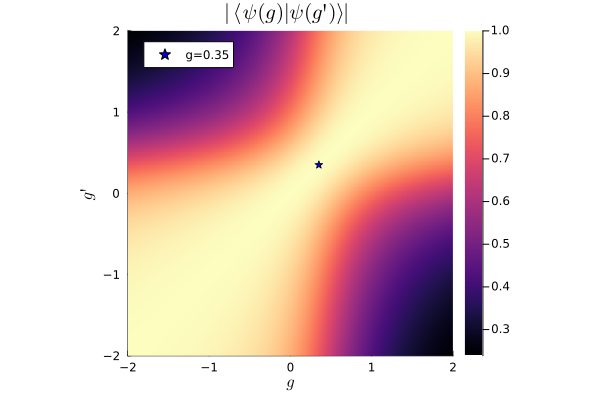

In [29]:
using Glob
using HDF5
using LaTeXStrings
using LinearAlgebra 
using Plots

function plot_overlap(Data)
    x = sort(collect(keys(Data)))
    mesh = zeros(Float64, length(x), length(x))
    for i = 1:length(x)
        g = x[i]; ψL = Data[g]
        for j = 1:length(x)
            gp = x[j]; ψR = Data[gp]
            mesh[i,j] = abs(dot(ψL, ψR))
        end
    end
    p = heatmap(x, x, mesh, c=:magma,
                aspect_ratio=1, xlims=(-2,2), ylims=(-2,2),
                xlabel=L"g", ylabel=L"g'", title=L"|  \langle \psi(g)|\psi(g') \rangle |")
    plot!(p, [0.35], [0.35], seriestype=:scatter, marker=:star, color=:blue, label="g=0.35")
    #savefig(p, "overlap.pdf")
    display(p)
end

Norb = 8; Nocc = 4
fns = glob("eigenstates_fullCI/eigenstate_Norb$(Norb)_Nocc$(Nocc)_g*.h5")
Data = Dict{Float64, Vector{Float64}}()
for fn in fns
    h5open(fn, "r") do file
        gval = read(file, "gval")
        evec = read(file, "evec")
        Data[gval] = evec        
    end
end

plot_overlap(Data)

$g \approx 0.35$(★)程度を境にoverlapの構造が変化しており、このあたりを境に波動関数の**質的な変化**が生じていることが見て取れる。